# Overview

### Target 
1. Since traing was noisy, we will use a dynamic learning rate. 

### Result 
1. Parameters: 8,870
2. Best Training Accuracy: 97.78
3. Best Test Accuracy: 98.54

### Analysis 
1. Training is much less noisy, but we compromised on accuracy now. 


# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
import matplotlib.pyplot as plt

# Data Transformations


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Model


In [ ]:
dropout_value = 0.1
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    # Convolution Block 1
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=10,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(10),nn.Dropout(dropout_value)
    )

    # Convolution Block 2
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=20,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(20),nn.Dropout(dropout_value)
    )

    # Transition Block 1
    self.transblock1 = nn.Sequential(
        nn.Conv2d(in_channels=20,out_channels=10,kernel_size=(1,1),padding = 0, bias = False),
        nn.MaxPool2d(2, 2), 
    )

    # Convolution Block 3
    self.convblock3 = nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=20,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(20),nn.Dropout(dropout_value)
    )

    # Convolution Block 4
    self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels=20,out_channels=10,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(10),nn.Dropout(dropout_value)
    )

    # Convolution Block 5
    self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=10,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(10),nn.Dropout(dropout_value)
    )

    self.convblock6 = nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=20,kernel_size=(3,3),padding = 1, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(20),nn.Dropout(dropout_value)
    )


    # Global average pooling layer
    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=6),
        nn.Conv2d(in_channels=20,out_channels=10,kernel_size=(1,1),padding = 0, bias = False)
    )

    self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

  
  def forward(self, x):

    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.transblock1(x)

    x = self.convblock3(x)
    x = self.convblock4(x)    
    x = self.convblock5(x)
    x = self.convblock6(x)
 
    x = self.gap(x)
    x = self.convblock7(x)
    x = x.view(-1,10)
    
    return F.log_softmax(x,dim = -1)


# Model Parameters

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
           Dropout-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,800
             ReLU-12           [-1, 20, 10, 10]               0
      BatchNorm2d-13           [-1, 20, 10, 10]              40
          Dropout-14           [-1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  
  train_losses.append(loss)
  train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=20)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.5490587949752808 Batch_id=468 Accuracy=33.08: 100%|██████████| 469/469 [00:21<00:00, 22.06it/s]



Test set: Average loss: 1.8165, Accuracy: 3298/10000 (32.98%)

EPOCH: 1


Loss=0.9775705933570862 Batch_id=468 Accuracy=54.69: 100%|██████████| 469/469 [00:21<00:00, 22.03it/s]



Test set: Average loss: 1.0601, Accuracy: 6359/10000 (63.59%)

EPOCH: 2


Loss=0.4807037115097046 Batch_id=468 Accuracy=80.87: 100%|██████████| 469/469 [00:21<00:00, 21.95it/s]



Test set: Average loss: 0.5343, Accuracy: 8708/10000 (87.08%)

EPOCH: 3


Loss=0.26837196946144104 Batch_id=468 Accuracy=90.48: 100%|██████████| 469/469 [00:21<00:00, 21.67it/s]



Test set: Average loss: 0.3103, Accuracy: 9233/10000 (92.33%)

EPOCH: 4


Loss=0.22964471578598022 Batch_id=468 Accuracy=93.19: 100%|██████████| 469/469 [00:21<00:00, 21.92it/s]



Test set: Average loss: 0.1983, Accuracy: 9485/10000 (94.85%)

EPOCH: 5


Loss=0.33533453941345215 Batch_id=468 Accuracy=94.47: 100%|██████████| 469/469 [00:21<00:00, 21.90it/s]



Test set: Average loss: 0.1734, Accuracy: 9530/10000 (95.30%)

EPOCH: 6


Loss=0.20070987939834595 Batch_id=468 Accuracy=95.20: 100%|██████████| 469/469 [00:21<00:00, 21.73it/s]



Test set: Average loss: 0.1269, Accuracy: 9652/10000 (96.52%)

EPOCH: 7


Loss=0.0932224914431572 Batch_id=468 Accuracy=95.71: 100%|██████████| 469/469 [00:21<00:00, 21.73it/s]



Test set: Average loss: 0.1083, Accuracy: 9689/10000 (96.89%)

EPOCH: 8


Loss=0.06685051321983337 Batch_id=468 Accuracy=96.13: 100%|██████████| 469/469 [00:21<00:00, 21.96it/s]



Test set: Average loss: 0.0994, Accuracy: 9717/10000 (97.17%)

EPOCH: 9


Loss=0.07337864488363266 Batch_id=468 Accuracy=96.42: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]



Test set: Average loss: 0.0923, Accuracy: 9733/10000 (97.33%)

EPOCH: 10


Loss=0.24893029034137726 Batch_id=468 Accuracy=96.64: 100%|██████████| 469/469 [00:21<00:00, 21.71it/s]



Test set: Average loss: 0.0811, Accuracy: 9766/10000 (97.66%)

EPOCH: 11


Loss=0.12322067469358444 Batch_id=468 Accuracy=96.81: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s]



Test set: Average loss: 0.0897, Accuracy: 9738/10000 (97.38%)

EPOCH: 12


Loss=0.11837562173604965 Batch_id=468 Accuracy=97.01: 100%|██████████| 469/469 [00:21<00:00, 21.89it/s]



Test set: Average loss: 0.0832, Accuracy: 9763/10000 (97.63%)

EPOCH: 13


Loss=0.041405294090509415 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]



Test set: Average loss: 0.0700, Accuracy: 9810/10000 (98.10%)

EPOCH: 14


Loss=0.0537620447576046 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:21<00:00, 21.73it/s]



Test set: Average loss: 0.0620, Accuracy: 9822/10000 (98.22%)

EPOCH: 15


Loss=0.0806623324751854 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]



Test set: Average loss: 0.0621, Accuracy: 9832/10000 (98.32%)

EPOCH: 16


Loss=0.05750559642910957 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:21<00:00, 21.42it/s]



Test set: Average loss: 0.0612, Accuracy: 9829/10000 (98.29%)

EPOCH: 17


Loss=0.05334734544157982 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:21<00:00, 21.62it/s]



Test set: Average loss: 0.0605, Accuracy: 9834/10000 (98.34%)

EPOCH: 18


Loss=0.09377363324165344 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:21<00:00, 21.63it/s]



Test set: Average loss: 0.0525, Accuracy: 9852/10000 (98.52%)

EPOCH: 19


Loss=0.04598574340343475 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:22<00:00, 21.30it/s]



Test set: Average loss: 0.0504, Accuracy: 9854/10000 (98.54%)



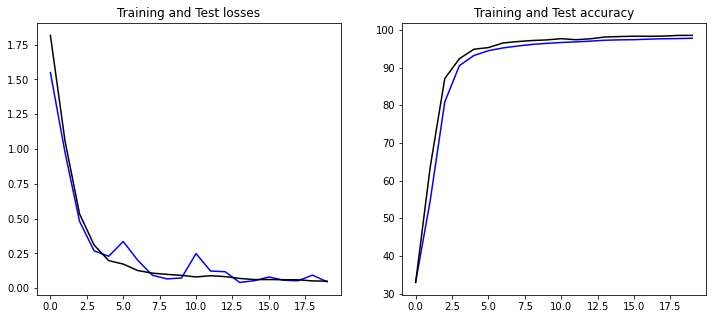

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(train_losses, c='blue')
ax1.plot(test_losses, c='black')
ax1.title.set_text('Training and Test losses')

ax2.plot(train_acc, c='blue')
ax2.plot(test_acc, c='black')
ax2.title.set_text('Training and Test accuracy')